# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of cereals production in Italy 2006-2022
#### Author: Maria Fisher 


The main objective of this study is to have gather information about crop production in Italy for the period of 2006-2022. 

Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).



In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
cereals = pd.read_csv('./Italy_crop_data/cereals_legumes.csv',skipinitialspace=True)
cereals.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2006,2006,17100.00,NaN,NaN
1,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2007,2007,21502.00,NaN,NaN
2,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2008,2008,23400.00,NaN,NaN
3,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2009,2009,23167.00,e,estimate data
4,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2010,2010,20904.00,e,estimate data


## Pre-processing dataset 

In [3]:
# Drop Columns
cereals = cereals.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
cereals

,Territory,Data type,Type of crop,Select time,Value
0,Torino,total area - hectares,common wheat,2006,17100.00
1,Torino,total area - hectares,common wheat,2007,21502.00
2,Torino,total area - hectares,common wheat,2008,23400.00
3,Torino,total area - hectares,common wheat,2009,23167.00
4,Torino,total area - hectares,common wheat,2010,20904.00
...,...,...,...,...,...
66260,Pesaro e Urbino,total area - hectares,rye and winter cereal mixtures (maslin),2022,3.00
66261,Roma,total area - hectares,rye and winter cereal mixtures (maslin),2022,20.00
66262,Valle d'Aosta / Vallée d'Aoste,total area - hectares,winter barley,2022,1.00
66263,Torino,total area - hectares,spring barley,2022,220.00


In [4]:
# Rename Columns
cereals = cereals.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(cereals):
    print('DATASET SHAPE: ', cereals.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(cereals.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(cereals.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(cereals.isnull().sum())
show_info(cereals)

DATASET SHAPE:  (66265, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66265 entries, 0 to 66264
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       66265 non-null  object 
 1   Data_type  66265 non-null  object 
 2   Type_crop  66265 non-null  object 
 3   Year       66265 non-null  int64  
 4   Value      66265 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.5+ MB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City           112
Data_type        3
Type_crop       29
Year            17
Value        14104
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing cereals

In [6]:
cereals.City.unique()


array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Savona', 'Genova', 'La Spezia', 'Varese', 'Como', 'Lecco',
       'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Lodi',
       'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Pordenone', 'Udine', 'Gorizia', 'Trieste', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca', 'Pistoia',
       'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo', 'Siena',
       'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino', 'Ancona',
       'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma', 'Latina',
       'Frosinone', "L'Aquila", 'Teramo', 'Pescara', 'Chieti', 'Isernia',
       'Campobasso', 'Caserta', 'Benevento', 'Avellino', 'Salerno',
       'Foggi

In [7]:
cereals.Data_type.unique()

array(['total area - hectares', 'total production - quintals ',
       'harvested production - quintals '], dtype=object)

## Select only Values for total production - quintals


In [8]:
cereals_total_prod = cereals[cereals['Data_type'] == 'total production - quintals ']
cereals_total_prod.head()

,City,Data_type,Type_crop,Year,Value
17,Torino,total production - quintals,common wheat,2006,1197000.00
18,Torino,total production - quintals,common wheat,2007,1333100.00
19,Torino,total production - quintals,common wheat,2008,1216800.00
20,Torino,total production - quintals,common wheat,2009,1149083.00
21,Torino,total production - quintals,common wheat,2010,1092994.00


In [9]:
cereals_total_prod['Value'] = cereals_total_prod['Value']/10
cereals_total_prod

,City,Data_type,Type_crop,Year,Value
17,Torino,total production - quintals,common wheat,2006,119700.00
18,Torino,total production - quintals,common wheat,2007,133310.00
19,Torino,total production - quintals,common wheat,2008,121680.00
20,Torino,total production - quintals,common wheat,2009,114908.30
21,Torino,total production - quintals,common wheat,2010,109299.40
...,...,...,...,...,...
66193,Trentino Alto Adige / Südtirol,total production - quintals,winter barley,2022,20.00
66198,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2021,189.00
66199,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2022,170.00
66204,Trentino Alto Adige / Südtirol,total production - quintals,oats and spring cereal mixtures (mixed grain o...,2021,37.20


In [10]:
cereals_total_prod = cereals_total_prod.rename(columns = {'Value':'Production_tonnes'})
cereals_total_prod

,City,Data_type,Type_crop,Year,Production_tonnes
17,Torino,total production - quintals,common wheat,2006,119700.00
18,Torino,total production - quintals,common wheat,2007,133310.00
19,Torino,total production - quintals,common wheat,2008,121680.00
20,Torino,total production - quintals,common wheat,2009,114908.30
21,Torino,total production - quintals,common wheat,2010,109299.40
...,...,...,...,...,...
66193,Trentino Alto Adige / Südtirol,total production - quintals,winter barley,2022,20.00
66198,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2021,189.00
66199,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2022,170.00
66204,Trentino Alto Adige / Südtirol,total production - quintals,oats and spring cereal mixtures (mixed grain o...,2021,37.20


In [11]:
cereals_total_prod =cereals_total_prod.drop(columns =['Data_type' ])
cereals_total_prod

,City,Type_crop,Year,Production_tonnes
17,Torino,common wheat,2006,119700.00
18,Torino,common wheat,2007,133310.00
19,Torino,common wheat,2008,121680.00
20,Torino,common wheat,2009,114908.30
21,Torino,common wheat,2010,109299.40
...,...,...,...,...
66193,Trentino Alto Adige / Südtirol,winter barley,2022,20.00
66198,Trentino Alto Adige / Südtirol,spring barley,2021,189.00
66199,Trentino Alto Adige / Südtirol,spring barley,2022,170.00
66204,Trentino Alto Adige / Südtirol,oats and spring cereal mixtures (mixed grain o...,2021,37.20


## Total cereal production in 2006-2022

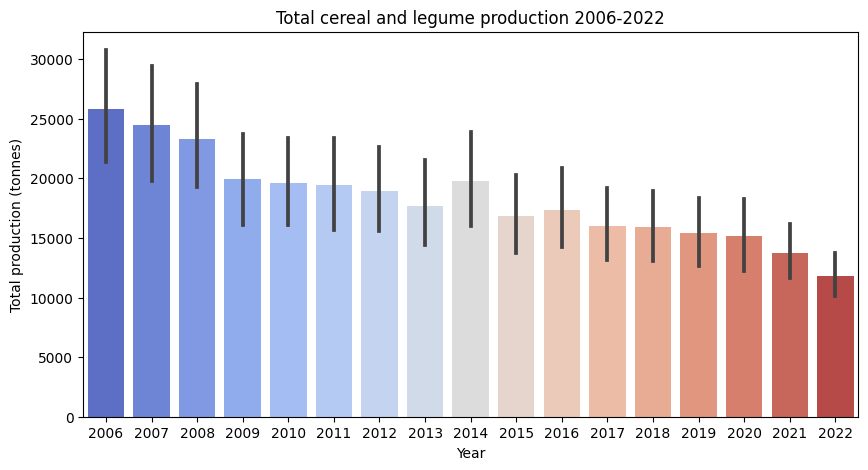

In [12]:
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Production_tonnes',data = cereals_total_prod,palette='coolwarm')
plt.title('Total cereal and legume production 2006-2022')
plt.xlabel('Year')
plt.ylabel('Total production (tonnes)')
plt.show()



## Cereal production by Cities 

In [13]:
cereals_total_prod_region = cereals_total_prod.groupby(by = cereals_total_prod.City)['Production_tonnes','City'].sum().reset_index().sort_values(by = 'Production_tonnes', ascending = False).head(10)
cereals_total_prod_region

,City,Production_tonnes
32,Ferrara,20270662.20
13,Bologna,18791123.30
34,Foggia,16076313.30
85,Rovigo,14803512.80
65,Padova,14378089.20
68,Pavia,13982908.90
51,Mantova,13557406.90
105,Venezia,13366469.20
96,Torino,13121296.00
29,Cuneo,10372357.70


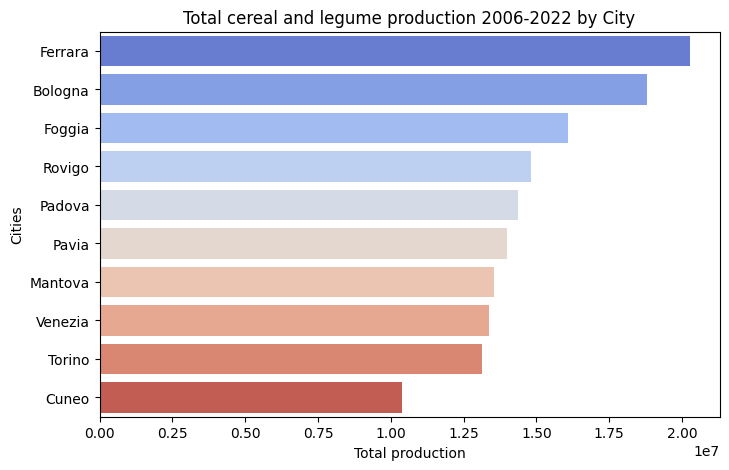

In [14]:
plt.figure(figsize= (8,5))
sns.barplot(x=cereals_total_prod_region['Production_tonnes'],y= cereals_total_prod_region['City'], orient='h', palette='coolwarm');
plt.title('Total cereal and legume production 2006-2022 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## Ital's geographic areas are organized in regions, provinces or comunes. 
### The regions are classified as follow:


#### Sud/Mezzogiorno:  

Abruzzo, Apulia/Puglia, Basilicata, Calabria, Campania, Molise, Sicily 

* Abruzzo: L'Aquila, Pescara, Chieti, Teramo

* Apulia/Puglia: Foggia, Bari, Taranto, Brindisi, Lecce, Barletta-Andria-Trani

* Basilicata: Matera, Potenza

* Calabria: Crotone, Vibo, Valentia, Cosenza, Catanzaro, Reggio di Calabria

* Campania: Benevento, Caserta, Napoli, Avellino, Salerno

* Molise: Campobasso, Isernia

* Sicilia: Messina,Siracusa, Agrigento, Caltanissetta, Trapani, Enna, Palermo, Catania, Ragusa

* Sardegna: Oristano, Carbonia-Iglesias, Olbia-Tempio, Ogliastr, Medio Campidano, Sassari, Nuoro, Cagliari



#### Centro: 

Toscana, Umbria, Marche, Lazio

* Toscana: Pistoia, Firenze, Massa-Carrara, Lucca, Arezzo, Livorno, Pisa, Grosseto, Siena, Prato

* Umbria: Perugia, Terni   

* Marche: Ancona, Macerata, Ascoli Piceno, Pesaro e Urbino, Fermo

* Lazio:  Roma, Viterbo, Rieti, Latina, Frosinone


#### Nord-ovest: 

Piemonte, Valle d’Aosta, Lombardia, Liguria

* Liguria: Imperia, Savona, Genova, La Spezia

* Lombardia: Como, Varese, Milano, Pavia, Bergamo, Brescia, Sondrio, Cremona, Mantova, Monza e Della Brianza, Lecco,Lodi

* Piemonte: Vercelli, Novara, Torino, Cuneo, Asti, Alessandria, Biella, Verbano-Cusio-Ossola

* Valdaosta:  Valle d'Aosta


#### Nord-est:

Trentino-Alto Adige, Veneto, Fiuli-Venezia Giulia, Emilia-Romagna


* Trentino: Bolzano/Bozen, Trento

* Veneto:  Belluno, Verona, Vicenza, Rovigo, Treviso, Venezia, Padova

* Friuli: Udine, Gorizia, Trieste, Pordenone

* Emilia-Romagna: Parma, Reggio Nell'Emilia, Piacenza, Forli'-Cesena, Modena, Bologna, Ferrara, Ravenna, Rimini











## Cereals highest production 2006-2022

In [15]:
print(cereals_total_prod.Type_crop.max())
print(cereals_total_prod.Type_crop.value_counts())
print(cereals_total_prod.Type_crop.nunique())



winter cereal mixtures (maslin)
potatoes                                                           1786
barley                                                             1733
grain maize                                                        1671
oats                                                               1650
common wheat                                                       1583
durum wheat                                                        1579
sorghum                                                            1246
dried kidney bean                                                  1239
broad bean                                                         1158
other cereals                                                      1148
chick-peas                                                         1088
protein pea                                                         949
rye                                                                 900
grain pea                       

Dataset shows there are 29 different types of cereals cultivated in Italy. Ten crop produced are Common wheat, Durum wheat, Potatoes, Barley, Maize, Beans, Chick-peas, Rye, Rice and Oats. 

In [16]:
cereals_total_prod.describe().astype(int)

,Year,Production_tonnes
count,22079,22079
mean,2014,17940
std,4,62404
min,2006,0
25%,2010,102
50%,2015,856
75%,2019,7210
max,2022,1016400


In [17]:
# Rename name of crops 
cereals_total_prod = cereals_total_prod.replace('oats and spring cereal mixtures (mixed grain other than maslin)','oats mix')
cereals_total_prod = cereals_total_prod.replace('rye and winter cereal mixtures (maslin)','rye mix')
cereals_total_prod = cereals_total_prod.replace('spring cereal mixtures (mixed grain other than maslin)','cereal mix')
cereals_total_prod = cereals_total_prod.replace('common spring wheat and spelt','c-spr-wheat&spelt')
cereals_total_prod = cereals_total_prod.replace('common winter wheat and spelt','c-wint-wheat&spelt')
cereals_total_prod = cereals_total_prod.replace('winter cereal mixtures (maslin)','wint-cereal-mix')
cereals_total_prod = cereals_total_prod.replace('dried kidney bean','dry-k-bean')
cereals_total_prod = cereals_total_prod.replace('common wheat','c-wheat')
cereals_total_prod = cereals_total_prod.replace('durum wheat','d-wheat')
cereals_total_prod = cereals_total_prod.replace('broad bean','bro-bean')
cereals_total_prod = cereals_total_prod.replace('grain maize','maize')



 

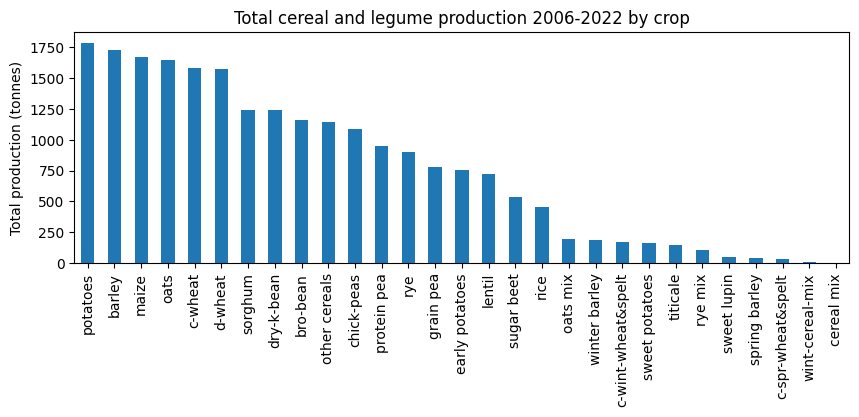

In [18]:
plt.figure(figsize=(10,3))
cereals_total_prod ['Type_crop'].value_counts().plot.bar()
plt.title('Total cereal and legume production 2006-2022 by crop')
plt.ylabel('Total production (tonnes)')
plt.show()


## Subseting data

In [19]:
cereals_top10 = cereals_total_prod.apply(lambda row: row[cereals_total_prod['Type_crop'].isin(['barley','oats', 
                                         'd-wheat','c-wheat', 'maize', 'potatoes','dry-k-bean',
                                          'bro-bean','chick-peas','rye'])])

cereals_top10.head()

,City,Type_crop,Year,Production_tonnes
17,Torino,c-wheat,2006,119700.00
18,Torino,c-wheat,2007,133310.00
19,Torino,c-wheat,2008,121680.00
20,Torino,c-wheat,2009,114908.30
21,Torino,c-wheat,2010,109299.40


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'c-wheat'),
  Text(1, 0, 'rye'),
  Text(2, 0, 'barley'),
  Text(3, 0, 'oats'),
  Text(4, 0, 'chick-peas'),
  Text(5, 0, 'd-wheat'),
  Text(6, 0, 'potatoes'),
  Text(7, 0, 'maize'),
  Text(8, 0, 'bro-bean'),
  Text(9, 0, 'dry-k-bean')])

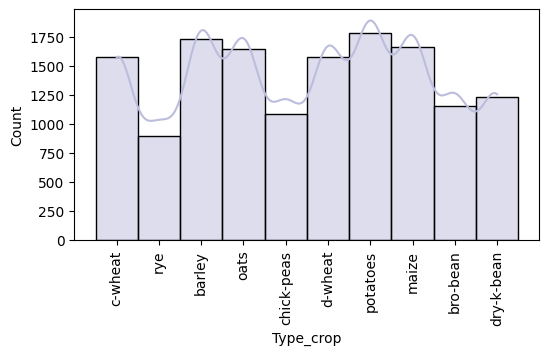

In [21]:
plt.figure(figsize=(6,3))
sns.histplot(cereals_top10, x="Type_crop", kde=True, color='#bcbddc')
plt.xticks(rotation = 90)

### Calculate and print the interquartile range

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).

Calculate and print the interquartile range

In [80]:
Q1 = cereals_top10.quantile(0.25)
Q3 = cereals_top10.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Year                   8.00
Production_tonnes   5153.20
dtype: float64


In [81]:
# Remove outliers
cereals_top10 = cereals_top10[~((cereals_top10 < (Q1 - 1.5 * IQR)) | (cereals_top10 > (Q3 + 1.5 * IQR))).any(axis=1)]
print(cereals_top10.shape)

(11122, 4)


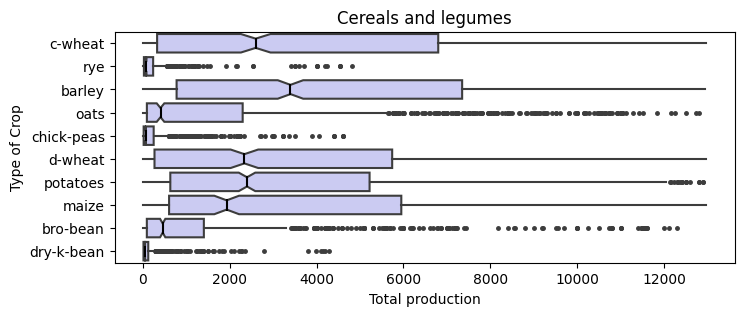

In [82]:
plt.figure(figsize=(8,3))

sns.boxplot(
    data=cereals_top10, y="Type_crop", x="Production_tonnes",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.6, .6, .9, .5)},
    medianprops={"color": "black"},
)

plt.title('Cereals and legumes')
plt.ylabel('Type of Crop')
plt.xlabel('Total production')
plt.show()

(0.0, 34752.06432927651)

<Figure size 500x300 with 0 Axes>

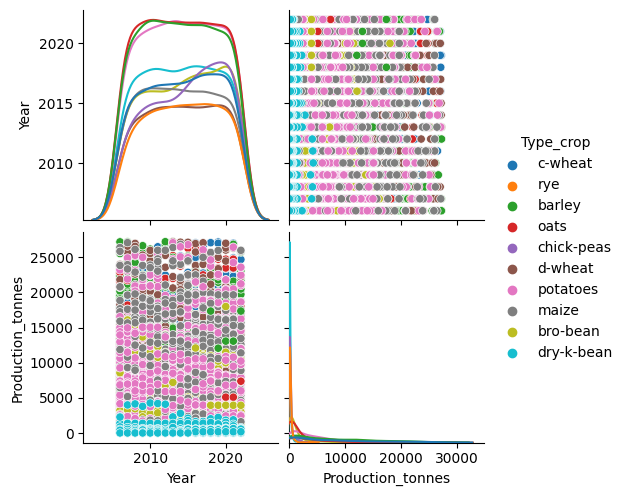

In [79]:
plt.figure(figsize=(5,3))
sns.pairplot(cereals_top10, hue="Type_crop", diag_kws=dict(fill=False))
plt.xlim(0, None)

In [85]:
cereals_top10.describe().astype(int)

,Year,Production_tonnes
count,11122,11122
mean,2014,2203
std,4,3184
min,2006,0
25%,2010,80
50%,2014,504
75%,2018,3240
max,2022,12969


## Vizualization of ten type of cereals and legumes produced in Italy in the period of 2006-2022 

<Figure size 500x300 with 0 Axes>

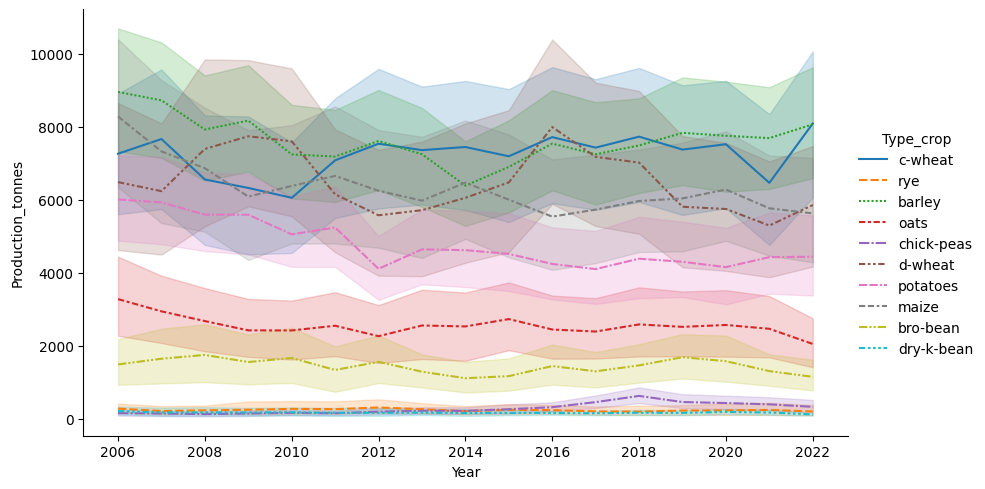

In [70]:
#Crop harvested by year
plt.figure(figsize=(5,3))
plotcrop10 = sns.relplot(kind='line', data=cereals_top10, x='Year', y='Production_tonnes', hue='Type_crop', style='Type_crop', aspect=1.75)


In [72]:
# Create columns for each type of fertilizer 

cereals_top10_pivot = cereals_top10.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_crop',values=['Production_tonnes'])
cereals_top10_pivot




Production_tonnes                                       \
Type_crop                 barley bro-bean  c-wheat chick-peas d-wheat   
City      Year                                                          
Agrigento 2006            897.00  7049.00      NaN     150.00     NaN   
          2007            840.00  6677.40      NaN     139.50     NaN   
          2008            925.00  7440.00      NaN     120.70     NaN   
          2009           1040.00  7040.00      NaN     123.30     NaN   
          2010           1187.00  7123.00      NaN     128.00     NaN   
...                          ...      ...      ...        ...     ...   
Viterbo   2018               NaN      NaN 11760.00    1120.00     NaN   
          2019               NaN      NaN 14000.00    1050.00     NaN   
          2020               NaN      NaN 13600.00    1010.00     NaN   
          2021               NaN      NaN 12900.00     985.00     NaN   
          2022               NaN      NaN 12500.00     980.00     NaN   

                                                            
Type_crop      dry-k-bean    maize    oats potatoes    rye  
City      Year                                              
Agrigento 2006      80.00      NaN  726.00  5075.00    NaN  
          2007      67.10      NaN  753.70  4787.30    NaN  
          2008      63.00      NaN  816.00  5624.00    NaN  
          2009      65.00      NaN  946.00  5810.00    NaN  
          2010      70.50      NaN 1070.00  8560.00    NaN  
...                   ...      ...     ...      ...    ...  
Viterbo   2018      66.00 19800.00 2650.00      NaN 504.00  
          2019      60.00 18000.00 3360.00      NaN 560.00  
          2020      59.00 17800.00 3110.00      NaN 510.00  
          2021      34.00 17250.00 3010.00      NaN 479.00  
          2022      33.00 17100.00 2900.00      NaN 469.00  

[1838 rows x 10 columns]

In [27]:

# Drop level
cereals_top10_pivot.columns = cereals_top10_pivot.columns.droplevel()
cereals_top10_pivot



Type_crop       barley  bro-bean  c-wheat  chick-peas  d-wheat  dry-k-bean  \
City      Year                                                               
Agrigento 2006  897.00   7049.00      NaN      150.00      NaN       80.00   
          2007  840.00   6677.40      NaN      139.50      NaN       67.10   
          2008  925.00   7440.00      NaN      120.70      NaN       63.00   
          2009 1040.00   7040.00      NaN      123.30      NaN       65.00   
          2010 1187.00   7123.00      NaN      128.00      NaN       70.50   
...                ...       ...      ...         ...      ...         ...   
Viterbo   2018     NaN       NaN 11760.00     1120.00      NaN       66.00   
          2019     NaN       NaN 14000.00     1050.00      NaN       60.00   
          2020     NaN       NaN 13600.00     1010.00      NaN       59.00   
          2021     NaN       NaN 12900.00      985.00      NaN       34.00   
          2022     NaN       NaN 12500.00      980.00      NaN       33.00   

Type_crop         maize    oats  potatoes    rye  
City      Year                                    
Agrigento 2006      NaN  726.00   5075.00    NaN  
          2007      NaN  753.70   4787.30    NaN  
          2008      NaN  816.00   5624.00    NaN  
          2009      NaN  946.00   5810.00    NaN  
          2010      NaN 1070.00   8560.00    NaN  
...                 ...     ...       ...    ...  
Viterbo   2018 19800.00 2650.00       NaN 504.00  
          2019 18000.00 3360.00       NaN 560.00  
          2020 17800.00 3110.00       NaN 510.00  
          2021 17250.00 3010.00       NaN 479.00  
          2022 17100.00 2900.00       NaN 469.00  

[1838 rows x 10 columns]

In [28]:
cereals_top10_pivot = cereals_top10_pivot.fillna(0)
cereals_top10_pivot



Type_crop       barley  bro-bean  c-wheat  chick-peas  d-wheat  dry-k-bean  \
City      Year                                                               
Agrigento 2006  897.00   7049.00     0.00      150.00     0.00       80.00   
          2007  840.00   6677.40     0.00      139.50     0.00       67.10   
          2008  925.00   7440.00     0.00      120.70     0.00       63.00   
          2009 1040.00   7040.00     0.00      123.30     0.00       65.00   
          2010 1187.00   7123.00     0.00      128.00     0.00       70.50   
...                ...       ...      ...         ...      ...         ...   
Viterbo   2018    0.00      0.00 11760.00     1120.00     0.00       66.00   
          2019    0.00      0.00 14000.00     1050.00     0.00       60.00   
          2020    0.00      0.00 13600.00     1010.00     0.00       59.00   
          2021    0.00      0.00 12900.00      985.00     0.00       34.00   
          2022    0.00      0.00 12500.00      980.00     0.00       33.00   

Type_crop         maize    oats  potatoes    rye  
City      Year                                    
Agrigento 2006     0.00  726.00   5075.00   0.00  
          2007     0.00  753.70   4787.30   0.00  
          2008     0.00  816.00   5624.00   0.00  
          2009     0.00  946.00   5810.00   0.00  
          2010     0.00 1070.00   8560.00   0.00  
...                 ...     ...       ...    ...  
Viterbo   2018 19800.00 2650.00      0.00 504.00  
          2019 18000.00 3360.00      0.00 560.00  
          2020 17800.00 3110.00      0.00 510.00  
          2021 17250.00 3010.00      0.00 479.00  
          2022 17100.00 2900.00      0.00 469.00  

[1838 rows x 10 columns]

In [29]:
#Rename index
cereals_top10_pivot = cereals_top10_pivot.rename_axis(None,axis=1)
cereals_top10_pivot



barley  bro-bean  c-wheat  chick-peas  d-wheat  dry-k-bean  \
City      Year                                                               
Agrigento 2006  897.00   7049.00     0.00      150.00     0.00       80.00   
          2007  840.00   6677.40     0.00      139.50     0.00       67.10   
          2008  925.00   7440.00     0.00      120.70     0.00       63.00   
          2009 1040.00   7040.00     0.00      123.30     0.00       65.00   
          2010 1187.00   7123.00     0.00      128.00     0.00       70.50   
...                ...       ...      ...         ...      ...         ...   
Viterbo   2018    0.00      0.00 11760.00     1120.00     0.00       66.00   
          2019    0.00      0.00 14000.00     1050.00     0.00       60.00   
          2020    0.00      0.00 13600.00     1010.00     0.00       59.00   
          2021    0.00      0.00 12900.00      985.00     0.00       34.00   
          2022    0.00      0.00 12500.00      980.00     0.00       33.00   

                  maize    oats  potatoes    rye  
City      Year                                    
Agrigento 2006     0.00  726.00   5075.00   0.00  
          2007     0.00  753.70   4787.30   0.00  
          2008     0.00  816.00   5624.00   0.00  
          2009     0.00  946.00   5810.00   0.00  
          2010     0.00 1070.00   8560.00   0.00  
...                 ...     ...       ...    ...  
Viterbo   2018 19800.00 2650.00      0.00 504.00  
          2019 18000.00 3360.00      0.00 560.00  
          2020 17800.00 3110.00      0.00 510.00  
          2021 17250.00 3010.00      0.00 479.00  
          2022 17100.00 2900.00      0.00 469.00  

[1838 rows x 10 columns]

In [30]:
# Reset index
cereals_top10_pivot = cereals_top10_pivot.reset_index()
cereals_top10_pivot

,City,Year,barley,bro-bean,c-wheat,chick-peas,d-wheat,dry-k-bean,maize,oats,potatoes,rye
0,Agrigento,2006,897.00,7049.00,0.00,150.00,0.00,80.00,0.00,726.00,5075.00,0.00
1,Agrigento,2007,840.00,6677.40,0.00,139.50,0.00,67.10,0.00,753.70,4787.30,0.00
2,Agrigento,2008,925.00,7440.00,0.00,120.70,0.00,63.00,0.00,816.00,5624.00,0.00
3,Agrigento,2009,1040.00,7040.00,0.00,123.30,0.00,65.00,0.00,946.00,5810.00,0.00
4,Agrigento,2010,1187.00,7123.00,0.00,128.00,0.00,70.50,0.00,1070.00,8560.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1833,Viterbo,2018,0.00,0.00,11760.00,1120.00,0.00,66.00,19800.00,2650.00,0.00,504.00
1834,Viterbo,2019,0.00,0.00,14000.00,1050.00,0.00,60.00,18000.00,3360.00,0.00,560.00
1835,Viterbo,2020,0.00,0.00,13600.00,1010.00,0.00,59.00,17800.00,3110.00,0.00,510.00
1836,Viterbo,2021,0.00,0.00,12900.00,985.00,0.00,34.00,17250.00,3010.00,0.00,479.00


## Statistical analysis

In [31]:
cereals_top10_pivot.describe()

,Year,barley,bro-bean,c-wheat,chick-peas,d-wheat,dry-k-bean,maize,oats,potatoes,rye
count,1838.00,1838.00,1838.00,1838.00,1838.00,1838.00,1838.00,1838.00,1838.00,1838.00,1838.00
mean,2014.00,6641.48,901.58,4472.87,178.86,3227.16,110.89,3651.77,2265.82,4140.63,115.56
std,4.86,7041.43,2092.36,6843.71,502.79,6098.84,335.72,5990.12,4315.32,5252.34,404.20
min,2006.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2010.00,360.00,0.00,0.00,0.00,0.00,0.00,0.00,52.58,360.00,0.00
50%,2014.00,4000.00,77.30,316.25,8.90,0.00,18.70,325.10,280.00,2175.00,0.00
75%,2018.00,11340.00,720.00,7000.00,96.00,3520.00,90.00,5113.50,2350.00,5898.25,77.25
max,2022.00,27225.00,18000.00,27180.00,4620.00,27216.10,4275.00,27086.50,26768.30,27070.00,4815.50


#### Data metrics : skew, kurtosis and mode

In [32]:
cereals_top10_pivot_stats = cereals_top10_pivot[['barley','bro-bean','c-wheat','chick-peas','d-wheat','dry-k-bean','maize','oats','potatoes','rye']]
print(cereals_top10_pivot_stats.astype(float).skew())
print(cereals_top10_pivot_stats.astype(float).kurtosis())
print(cereals_top10_pivot_stats.astype(float).mode())


barley       0.98
bro-bean     3.80
c-wheat      1.59
chick-peas   4.92
d-wheat      2.19
dry-k-bean   7.55
maize        1.82
oats         2.96
potatoes     1.88
rye          7.94
dtype: float64
barley       -0.06
bro-bean     16.57
c-wheat       1.50
chick-peas   29.66
d-wheat       4.07
dry-k-bean   73.21
maize         2.51
oats          9.77
potatoes      3.48
rye          73.27
dtype: float64
   barley  bro-bean  c-wheat  chick-peas  d-wheat  dry-k-bean  maize  oats  \
0    0.00      0.00     0.00        0.00     0.00        0.00   0.00  0.00   

   potatoes  rye  
0      0.00 0.00  


### Graphs
#### Histogram and Boxplot showing data distribuion and outliers¶


### Normalizing the dataset

The data need to be normalized for further use in a modelling. Here the data will be normalize by deleting outliers using the interquartile range (IQR).


#### Calculate and print the interquartile range

(1838, 12)


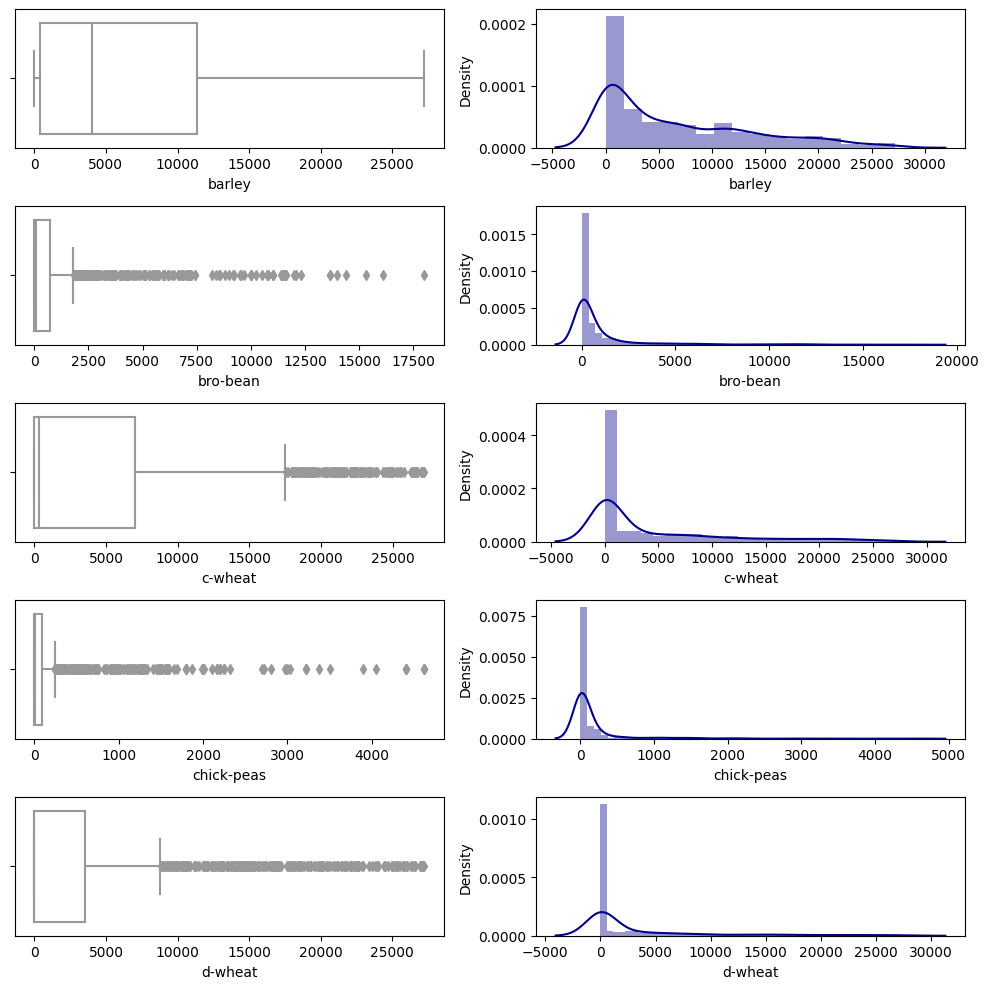

In [35]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= cereals_top10_pivot_stats["barley"], color = 'white', ax = ax[0,0])
sns.distplot(cereals_top10_pivot_stats['barley'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= cereals_top10_pivot_stats["bro-bean"],color = 'white', ax = ax[1,0])
sns.distplot(cereals_top10_pivot_stats['bro-bean'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= cereals_top10_pivot_stats["c-wheat"],color = 'white', ax = ax[2,0])
sns.distplot(cereals_top10_pivot_stats['c-wheat'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= cereals_top10_pivot_stats["chick-peas"], color = 'white', ax = ax[3,0])
sns.distplot(cereals_top10_pivot_stats['chick-peas'], color = 'darkblue', ax = ax[3,1])
sns.boxplot(x= cereals_top10_pivot_stats["d-wheat"], color = 'white',ax = ax[4,0])
sns.distplot(cereals_top10_pivot_stats['d-wheat'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

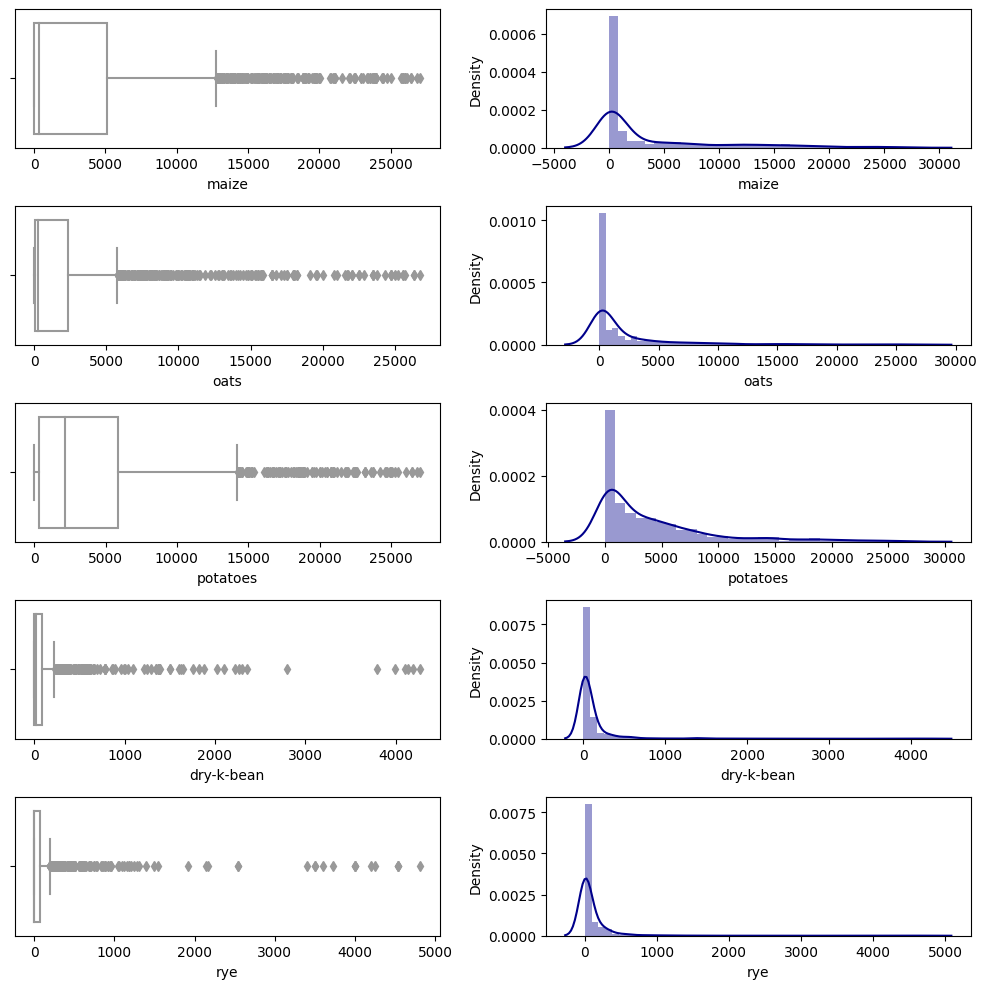

In [36]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
sns.boxplot(x= cereals_top10_pivot_stats["maize"], color = 'white', ax = ax[0,0])
sns.distplot(cereals_top10_pivot_stats['maize'], color = 'darkblue', ax = ax[0,1])
sns.boxplot(x= cereals_top10_pivot_stats["oats"],color = 'white', ax = ax[1,0])
sns.distplot(cereals_top10_pivot_stats['oats'], color = 'darkblue', ax = ax[1,1])
sns.boxplot(x= cereals_top10_pivot_stats["potatoes"],color = 'white', ax = ax[2,0])
sns.distplot(cereals_top10_pivot_stats['potatoes'], color = 'darkblue',ax = ax[2,1])
sns.boxplot(x= cereals_top10_pivot_stats["dry-k-bean"], color = 'white',ax = ax[3,0])
sns.distplot(cereals_top10_pivot_stats['dry-k-bean'], color = 'darkblue',ax = ax[3,1])
sns.boxplot(x= cereals_top10_pivot_stats["rye"], color = 'white',ax = ax[4,0])
sns.distplot(cereals_top10_pivot_stats['rye'], color = 'darkblue',ax = ax[4,1])

plt.tight_layout()

In [37]:
cereals_top10_pivot

,City,Year,barley,bro-bean,c-wheat,chick-peas,d-wheat,dry-k-bean,maize,oats,potatoes,rye
0,Agrigento,2006,897.00,7049.00,0.00,150.00,0.00,80.00,0.00,726.00,5075.00,0.00
1,Agrigento,2007,840.00,6677.40,0.00,139.50,0.00,67.10,0.00,753.70,4787.30,0.00
2,Agrigento,2008,925.00,7440.00,0.00,120.70,0.00,63.00,0.00,816.00,5624.00,0.00
3,Agrigento,2009,1040.00,7040.00,0.00,123.30,0.00,65.00,0.00,946.00,5810.00,0.00
4,Agrigento,2010,1187.00,7123.00,0.00,128.00,0.00,70.50,0.00,1070.00,8560.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1833,Viterbo,2018,0.00,0.00,11760.00,1120.00,0.00,66.00,19800.00,2650.00,0.00,504.00
1834,Viterbo,2019,0.00,0.00,14000.00,1050.00,0.00,60.00,18000.00,3360.00,0.00,560.00
1835,Viterbo,2020,0.00,0.00,13600.00,1010.00,0.00,59.00,17800.00,3110.00,0.00,510.00
1836,Viterbo,2021,0.00,0.00,12900.00,985.00,0.00,34.00,17250.00,3010.00,0.00,479.00


### Pre-processing ferlizers dataset
fertilizers distributed - tonnes

In [38]:
    fertilizer = pd.read_csv('fertilizer_by_prov.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2006,2006,1227,NaN,NaN
1,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2007,2007,1812,NaN,NaN
2,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2008,2008,5224,NaN,NaN
3,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2009,2009,2051,NaN,NaN
4,ITC11,Torino,FERT_DISTRIB_Q,fertilizers distributed - quintals,AZOTATI_CALCIO,calcium cyanamide,2010,2010,54,NaN,NaN


In [39]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags'])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [40]:
# change name of columns
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,1227
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,1812
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,5224
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,2051
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,54
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [41]:
fertilizer.City.unique()

array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Imperia', 'Savona', 'Genova', 'La Spezia', 'Varese', 'Como',
       'Lecco', 'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia',
       'Lodi', 'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol',
       'Provincia Autonoma Bolzano / Bozen', 'Provincia Autonoma Trento',
       'Verona', 'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova',
       'Rovigo', 'Pordenone', 'Udine', 'Gorizia', 'Trieste', 'Piacenza',
       'Parma', "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara',
       'Ravenna', 'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca',
       'Pistoia', 'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo',
       'Siena', 'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino',
       'Ancona', 'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma',
       'Latina', 'Frosinone', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       

In [42]:
fertilizer.Data_type.unique()

array(['fertilizers distributed - quintals',
       'fertilizers distributed - tonnes'], dtype=object)

In [43]:
#convert quintals to tonnes
fertilizer.loc[fertilizer['Data_type'] == 'fertilizers distributed - quintals','Fertilizers_tonnes' ] = fertilizer['Fertilizers_tonnes'] / 10



In [44]:
fertilizer.Data_type.unique()

array(['fertilizers distributed - quintals',
       'fertilizers distributed - tonnes'], dtype=object)

In [45]:
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,fertilizers distributed - quintals,calcium cyanamide,2006,122.70
1,Torino,fertilizers distributed - quintals,calcium cyanamide,2007,181.20
2,Torino,fertilizers distributed - quintals,calcium cyanamide,2008,522.40
3,Torino,fertilizers distributed - quintals,calcium cyanamide,2009,205.10
4,Torino,fertilizers distributed - quintals,calcium cyanamide,2010,5.40
...,...,...,...,...,...
68381,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2017,335.00
68382,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2018,137.00
68383,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164.00
68384,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135.00


### Selecting fertilizers for future analysis 

In [46]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())
print(fertilizer.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               3497
three components - nitrogen-phosphorous-phosphorous                                      1941
containing only one secondary macronutrient - magnesium oxide                            1749
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
peaty soil amendment                                                                     1749
mixed soil amendment                                                                     1749
vegetable soil amendment                                                                 1749
organic-mineral fertilizers - compound                                                   1749
organic-mineral fertilizers - straight nitrogen                                          1749
organic fertilizers - compound     

In [47]:
# Rename name of fertilizers 
fertilizer = fertilizer.replace('organic fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - straight nitrogen','organic-nitrogen')
fertilizer = fertilizer.replace('organic-mineral fertilizers - compound','organic-mineral')
fertilizer = fertilizer.replace('organic fertilizers - compound','organic')
fertilizer = fertilizer.replace('mixed soil amendment','mix-amend')
fertilizer = fertilizer.replace('peaty soil amendment','peaty-amend')
fertilizer = fertilizer.replace('peaty amendment','peaty-amend')
fertilizer = fertilizer.replace('peat amendment','peaty-amend')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - nitrogen-potassium','nitrogen-potassium')
fertilizer = fertilizer.replace('two components - nitrogen-phosphorous','nitrogen-phosphorous')
fertilizer = fertilizer.replace('two components - phosphorus-potassium','phosphorus-potassium')
fertilizer = fertilizer.replace('vegetable soil amendment', 'organic')

In [48]:
print(fertilizer.Type_fertilizer.max())
print(fertilizer.Type_fertilizer.value_counts())


urea
organic                                                                                  3498
organic-nitrogen                                                                         3498
specific action products -                                                               3497
peaty-amend                                                                              3497
three components - nitrogen-phosphorous-phosphorous                                      1941
soil correctives - other  soil correctives                                               1749
other soil amendments                                                                    1749
mix-amend                                                                                1749
organic-mineral                                                                          1749
containing micronutrients containing only a micronutrient in chelated form               1749
containing micronutrients containing only a micronutrie

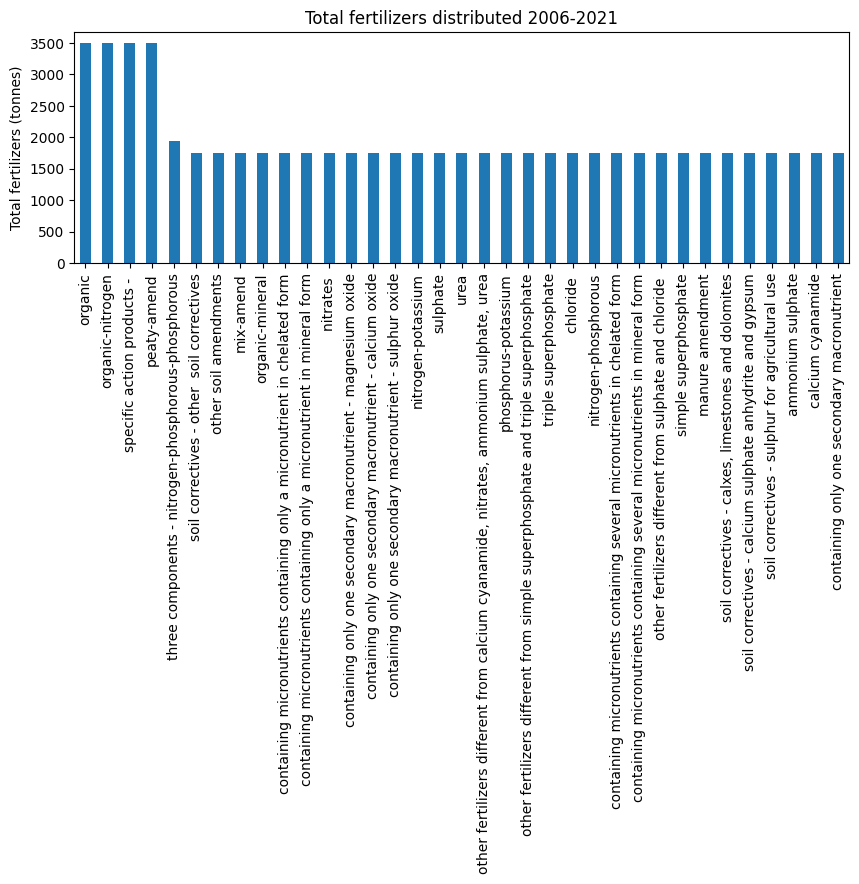

In [49]:
plt.figure(figsize=(10,3))
fertilizer['Type_fertilizer'].value_counts().plot.bar()
plt.title('Total fertilizers distributed 2006-2021')
plt.ylabel('Total fertilizers (tonnes)')
plt.show()

In [50]:
fertilizer = fertilizer.apply(lambda row: row[fertilizer['Type_fertilizer'].isin(['organic','nitrogen-potassium','nitrogen-phosphorous' ])])

fertilizer.head()

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
88,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2006,13448.70
89,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2007,15689.30
90,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2008,8672.40
91,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2009,7766.90
92,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2010,9253.30


In [51]:
fertilizer.Data_type.unique()

array(['fertilizers distributed - quintals',
       'fertilizers distributed - tonnes'], dtype=object)

In [52]:
fertilizer.describe()

,Year,Fertilizers_tonnes
count,6996.00,6996.00
mean,2013.49,1539.15
std,4.59,3587.48
min,2006.00,0.00
25%,2010.00,45.98
50%,2013.00,371.00
75%,2017.00,1544.62
max,2021.00,98671.60


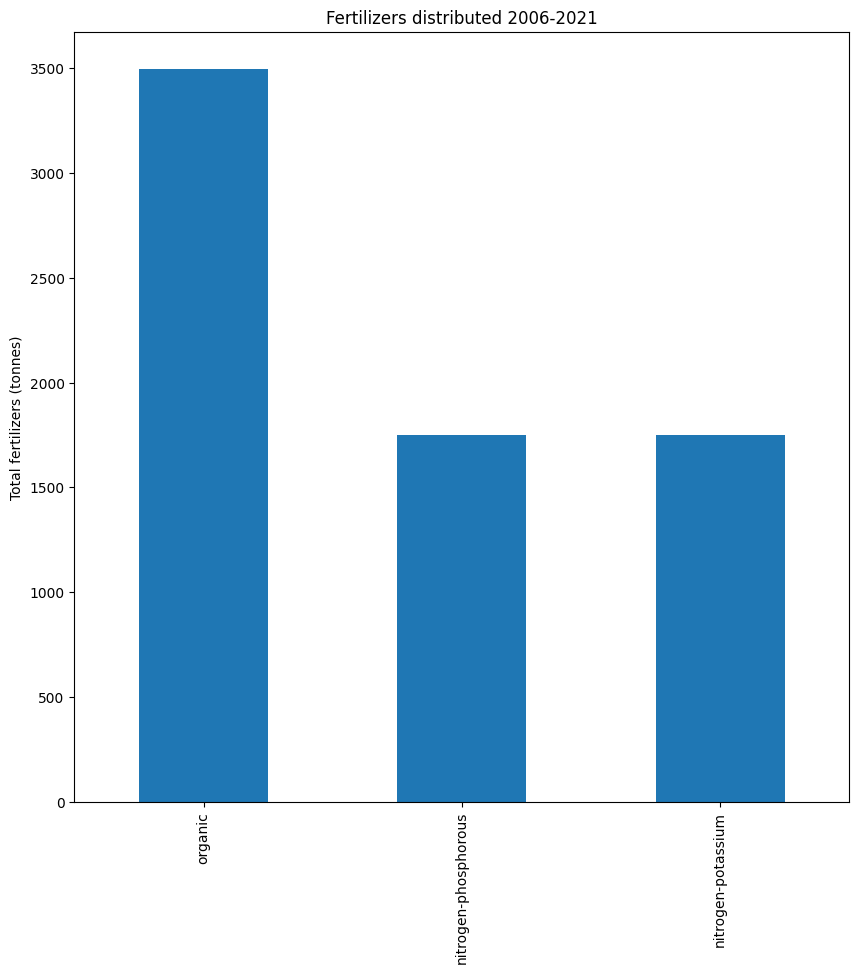

In [53]:

plt.figure(figsize=(10,10))
fertilizer['Type_fertilizer'].value_counts().plot.bar()
plt.title('Fertilizers distributed 2006-2021')
plt.ylabel('Total fertilizers (tonnes)')
plt.show()


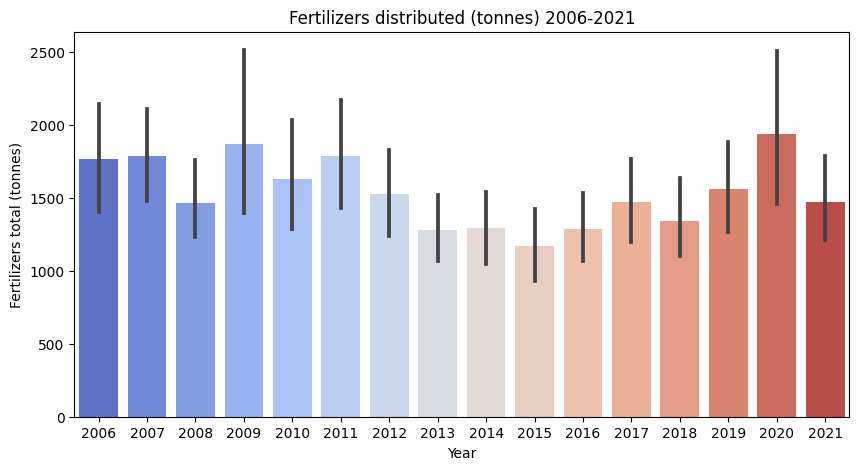

In [54]:
# fertilizer distributed tonnes and quintals
plt.figure(figsize= (10,5))
sns.barplot(x= 'Year', y= 'Fertilizers_tonnes',data = fertilizer, palette='coolwarm')
plt.title('Fertilizers distributed (tonnes) 2006-2021')
plt.xlabel('Year')
plt.ylabel('Fertilizers total (tonnes)')
plt.show()


In [55]:
fertilizer30 = fertilizer.nlargest(30, 'Fertilizers_tonnes')

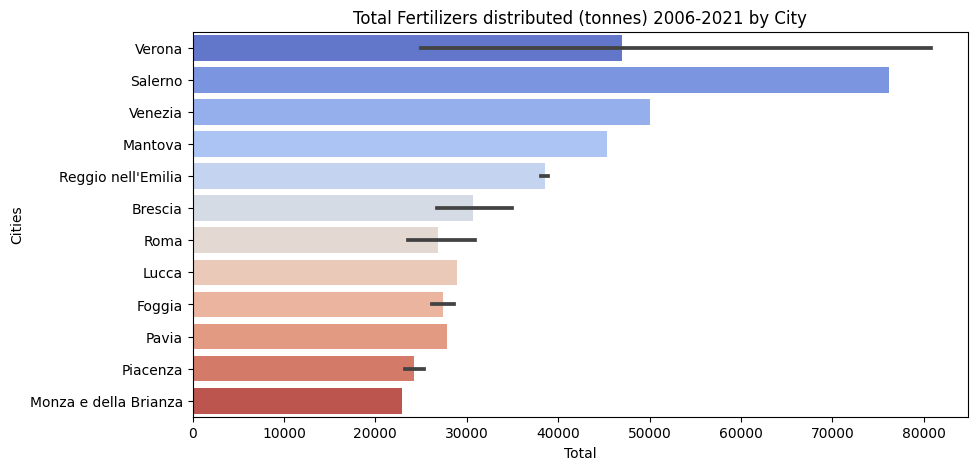

In [56]:
fertilizer30= fertilizer30.sort_values('Fertilizers_tonnes',ascending=False)

plt.figure(figsize= (10,5))
sns.barplot(x=fertilizer30['Fertilizers_tonnes'] ,y= fertilizer30 ['City'], palette='coolwarm');
plt.title('Total Fertilizers distributed (tonnes) 2006-2021 by City')
plt.xlabel('Total')
plt.ylabel('Cities')
plt.show()

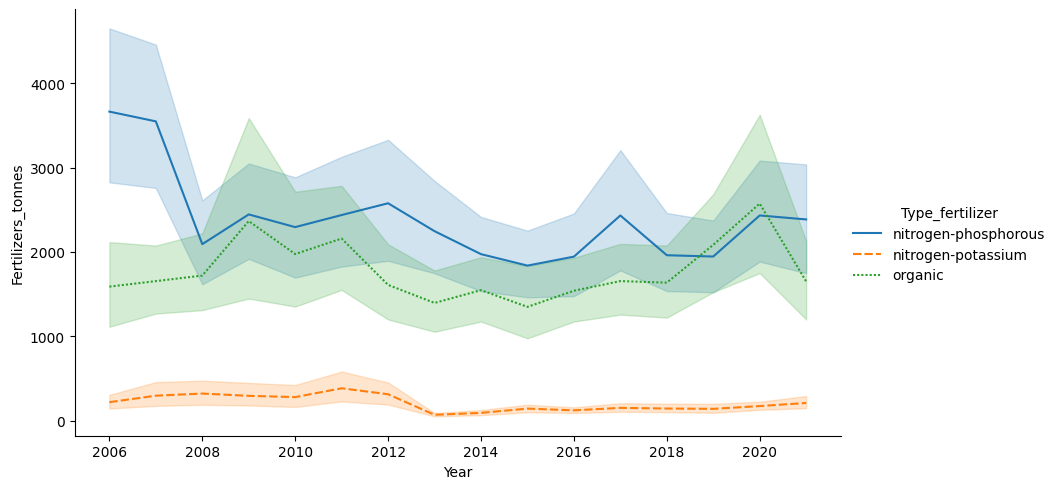

In [57]:
#Fertilizers distributed by year

fertilizer_plot = sns.relplot(kind='line', data=fertilizer, x='Year', y='Fertilizers_tonnes', hue='Type_fertilizer', style='Type_fertilizer', aspect=1.75)


In [58]:
fertilizer.head()

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
88,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2006,13448.70
89,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2007,15689.30
90,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2008,8672.40
91,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2009,7766.90
92,Torino,fertilizers distributed - quintals,nitrogen-phosphorous,2010,9253.30


In [59]:
fertilizer.describe()

,Year,Fertilizers_tonnes
count,6996.00,6996.00
mean,2013.49,1539.15
std,4.59,3587.48
min,2006.00,0.00
25%,2010.00,45.98
50%,2013.00,371.00
75%,2017.00,1544.62
max,2021.00,98671.60


#### Create new dataframe with the selected type of fertilizers as columns  

In [60]:
# Create columns for each type of fertilizer 
fertilizer_pivot = fertilizer.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer_pivot

Fertilizers_tonnes                           
Type_fertilizer nitrogen-phosphorous nitrogen-potassium organic
City      Year                                                 
Agrigento 2006                497.70              27.70 3143.90
          2007                649.80              49.10 3534.80
          2008                521.30              61.40 3750.40
          2009                380.80              46.80 2791.40
          2010                327.10              44.00 2346.00
...                              ...                ...     ...
Viterbo   2017               4732.00              66.00 1760.00
          2018               4376.00              19.00 1591.00
          2019               3964.00             195.00 1251.00
          2020               6145.00              98.00 1236.00
          2021               3946.00             112.00 1056.00

[1749 rows x 3 columns]

In [61]:
# Drop level
fertilizer_pivot.columns = fertilizer_pivot.columns.droplevel()
fertilizer_pivot

Type_fertilizer  nitrogen-phosphorous  nitrogen-potassium  organic
City      Year                                                    
Agrigento 2006                 497.70               27.70  3143.90
          2007                 649.80               49.10  3534.80
          2008                 521.30               61.40  3750.40
          2009                 380.80               46.80  2791.40
          2010                 327.10               44.00  2346.00
...                               ...                 ...      ...
Viterbo   2017                4732.00               66.00  1760.00
          2018                4376.00               19.00  1591.00
          2019                3964.00              195.00  1251.00
          2020                6145.00               98.00  1236.00
          2021                3946.00              112.00  1056.00

[1749 rows x 3 columns]

In [62]:
#Rename index
fertilizer_pivot = fertilizer_pivot.rename_axis(None,axis=1)
fertilizer_pivot

nitrogen-phosphorous  nitrogen-potassium  organic
City      Year                                                   
Agrigento 2006                497.70               27.70  3143.90
          2007                649.80               49.10  3534.80
          2008                521.30               61.40  3750.40
          2009                380.80               46.80  2791.40
          2010                327.10               44.00  2346.00
...                              ...                 ...      ...
Viterbo   2017               4732.00               66.00  1760.00
          2018               4376.00               19.00  1591.00
          2019               3964.00              195.00  1251.00
          2020               6145.00               98.00  1236.00
          2021               3946.00              112.00  1056.00

[1749 rows x 3 columns]

In [63]:
# Reset index
fertilizer_pivot = fertilizer_pivot.reset_index()
fertilizer_pivot

,City,Year,nitrogen-phosphorous,nitrogen-potassium,organic
0,Agrigento,2006,497.70,27.70,3143.90
1,Agrigento,2007,649.80,49.10,3534.80
2,Agrigento,2008,521.30,61.40,3750.40
3,Agrigento,2009,380.80,46.80,2791.40
4,Agrigento,2010,327.10,44.00,2346.00
...,...,...,...,...,...
1744,Viterbo,2017,4732.00,66.00,1760.00
1745,Viterbo,2018,4376.00,19.00,1591.00
1746,Viterbo,2019,3964.00,195.00,1251.00
1747,Viterbo,2020,6145.00,98.00,1236.00


#### Join crop and fertilizers datasets 

In [64]:
# Join both datasets 
it_crop_fertilizer = pd.merge(cereals_top10_pivot, fertilizer_pivot, on=['Year', 'City'], how='left').fillna(0)
it_crop_fertilizer

,City,Year,barley,bro-bean,c-wheat,chick-peas,d-wheat,dry-k-bean,maize,oats,potatoes,rye,nitrogen-phosphorous,nitrogen-potassium,organic
0,Agrigento,2006,897.00,7049.00,0.00,150.00,0.00,80.00,0.00,726.00,5075.00,0.00,497.70,27.70,3143.90
1,Agrigento,2007,840.00,6677.40,0.00,139.50,0.00,67.10,0.00,753.70,4787.30,0.00,649.80,49.10,3534.80
2,Agrigento,2008,925.00,7440.00,0.00,120.70,0.00,63.00,0.00,816.00,5624.00,0.00,521.30,61.40,3750.40
3,Agrigento,2009,1040.00,7040.00,0.00,123.30,0.00,65.00,0.00,946.00,5810.00,0.00,380.80,46.80,2791.40
4,Agrigento,2010,1187.00,7123.00,0.00,128.00,0.00,70.50,0.00,1070.00,8560.00,0.00,327.10,44.00,2346.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833,Viterbo,2018,0.00,0.00,11760.00,1120.00,0.00,66.00,19800.00,2650.00,0.00,504.00,4376.00,19.00,1591.00
1834,Viterbo,2019,0.00,0.00,14000.00,1050.00,0.00,60.00,18000.00,3360.00,0.00,560.00,3964.00,195.00,1251.00
1835,Viterbo,2020,0.00,0.00,13600.00,1010.00,0.00,59.00,17800.00,3110.00,0.00,510.00,6145.00,98.00,1236.00
1836,Viterbo,2021,0.00,0.00,12900.00,985.00,0.00,34.00,17250.00,3010.00,0.00,479.00,3946.00,112.00,1056.00


In [65]:
cereal_fert= it_crop_fertilizer.to_csv('cereal_fert.csv')


### Correlation analysis


In [66]:

crop = it_crop_fertilizer.City.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_fertilizer['target']=crop.cat.codes

cor_selected = it_crop_fertilizer[['barley','oats','d-wheat','c-wheat', 'maize',
                                 'potatoes','dry-k-bean','bro-bean','chick-peas',
                                 'rye','organic','nitrogen-potassium',
                                   'nitrogen-phosphorous']]


<AxesSubplot: title={'center': 'Correlation cereals & legumes 2006-2021'}>

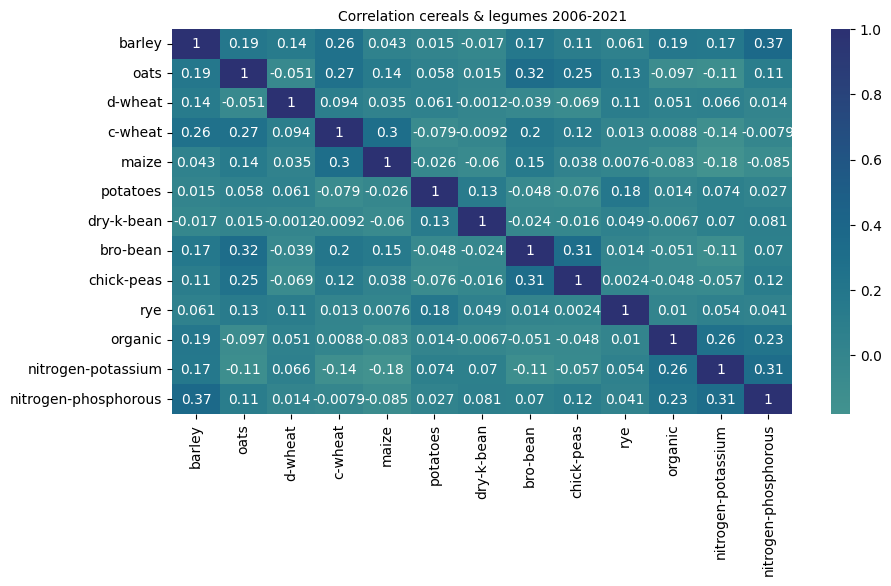

In [67]:
plt.figure(figsize=(10,5))
plt.title('Correlation cereals & legumes 2006-2021', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

### Correlation analysis of cereal and legumes production in Italy 2006 -2021 : 
there is low correlation between cereals, legumes and fertilizers. 

### Calculating Variance Inflation Factor (VIF) for all given features



In [68]:
# Function to compute the VIF
def compute_vif(selected_features):
    
    y = cor_selected [selected_features]
    # the calculation of variance inflation requires a constant
    y['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Feature"] = y.columns
    vif["VIF"] = [variance_inflation_factor(y.values, i) for i in range(y.shape[1])]
    vif = vif[vif['Feature']!='intercept']
    return vif

In [69]:
# Features selection
selected_features = ['barley','oats','d-wheat','c-wheat', 'maize',
                                 'potatoes','dry-k-bean','bro-bean','chick-peas',
                                 'rye','organic','nitrogen-potassium',
                                   'nitrogen-phosphorous']

# compute vif 
compute_vif(selected_features).sort_values('VIF', ascending=False)


,Feature,VIF
0,barley,1.34
12,nitrogen-phosphorous,1.31
3,c-wheat,1.28
1,oats,1.28
11,nitrogen-potassium,1.23
7,bro-bean,1.23
8,chick-peas,1.16
4,maize,1.14
10,organic,1.14
5,potatoes,1.07


We have performed variance inflation factor (VIF) to detect if there is multicollinearity. VIF greater or equal to 5 idicates serious collinearity problem.  

In this analysis none of the features showed VIF higher than 5.  
 

Modelling*

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html

https://www.statisticshowto.com/variance-inflation-factor/

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/